<a href="https://colab.research.google.com/github/tarnowska/CSUPERB_DL/blob/master/Copy_of_small_embryo_Transfer_Learning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Transfer Learning for Biomedical Image Data

Deep learning has been successfully used to accurately classify many types of biomedical image data. In collaboration with Dr Ilmi Yoon and her graduate students, the accuracy of the classification of images of tadpole (frog) embryos stained with muscle and intersomitic boundaries was improved using deep transfer learning. This notebook outlines the core algorithm used for this task in a general way, so that future experiments with novel datasets can easily be conducted.

## Background

Before any code is run, it is important to understand some basics of neural networks and transfer learning.


### Deep Neural Networks
A deep neural network can be thought of as a conditional probability estimator which can predict the probability of some condition given some input. This project uses the VGG16 network architecture, which accepts color images as input and predicts the probability that the image belogs to any of 1000 classes general image classes.


### Transfer Learning
Transfer learning is the process fine-tuning a well trained neural network (like VGG16) for a specific task. This has been proven to be effective at classifying medical image data with minimal training time and smaller datasets than would otherwise be required for human level performance. In this project, the output layer with 1000 classes is replaced with a custom layer with only two classes (control and mutant). The network is then retrained with a small hand-labeled dataset to achieve an accuracy of 98%.

## Introduction to Colab Notebooks

### Running a Code Cell

The cell below is written in python code. In order to execute a cell, press the play button next to the cell, or press Shift-Enter while within a code cell. The output generated by a cell will be shown below the cell. Try executing the cell below.

In [0]:
print('Hello World')


Hello World


The output should read 'Hello World'. 


### Configuring the Virtual Interpreter
The code cells are run on a virtual interpereter. To ensure that the code is executed efficiently, GPU processing must be enabled:

* Navigate to 'Runtime' > 'Change Runtime Type'
* Ensure that 'Hardware Accelerator' is set to 'GPU'

In [0]:
!nvidia-smi --list-gpus

GPU 0: Tesla T4 (UUID: GPU-46354f69-02db-142e-fda5-f294441fddb5)


### Downloading the Data
Ensure that you have uploaded the dataset to the colab environment.

In [0]:
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=14waYTxv4l4WHp7BvnY4xTBTqTQlGRl0u'
# url = 'https://drive.google.com/uc?id=14bW8k2QYj7aR9-YZL9vVg2FqqfbylvZS'
output = 'embryo_small.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14waYTxv4l4WHp7BvnY4xTBTqTQlGRl0u
To: /content/embryo_small.zip
10.8MB [00:00, 126MB/s]


'embryo_small.zip'

### Importing the Software Libraries

The following code imports some software libraries necessary to execute the project. 

In [0]:
%tensorflow_version 2.x
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline 
print("Import Success!")

Import Success!


## Working with Training Data

The data must be loaded into the Keras API so that it can be easily fed to the machine learning model.


### Extract the Data

First, the images must be extracted.


In [0]:
!unzip embryo_small.zip
print("Done.")

Archive:  embryo_small.zip
   creating: embryo_small/
  inflating: __MACOSX/._embryo_small  
   creating: embryo_small/testData/
  inflating: embryo_small/.DS_Store  
  inflating: __MACOSX/embryo_small/._.DS_Store  
   creating: embryo_small/datasets/
   creating: embryo_small/models/
   creating: embryo_small/testData/mutant/
   creating: embryo_small/testData/control/
   creating: embryo_small/datasets/mutant/
   creating: embryo_small/datasets/control/
  inflating: embryo_small/models/noglobal-VGG16-20200113-144229.txt  
  inflating: embryo_small/models/noglobal-VGG16-20200113-144003.txt  
  inflating: embryo_small/models/testsize-VGG16-20200113-123719.txt  
  inflating: embryo_small/models/test-VGG16-20200113-182736.txt  
  inflating: embryo_small/models/noglobal-VGG16-20200113-144229classes.py  
  inflating: embryo_small/models/params-VGG16-20200113-122825.txt  
  inflating: embryo_small/models/pname-VGG16-20200113-121724classes.py  
  inflating: embryo_small/models/params-VGG16-2

### Splitting the Dataset

The data is divided in to three sets: train, validation, and test. The training data will be used to train the model. The validation data will be run through the model occationally to ensure that it is generalizing well to input outside the training cases (not overfitting). Therefore, this data is used to determine the optimal amount of training. The test data will be kept until we are completely done in order to measure our peformance. 

In [0]:
train_path = 'embryo_small/datasets'
test_path = 'embryo_small/testData'
print("Paths Loaded.")

Paths Loaded.


### Creating the Data Generators

A useful interface for feeding data into our model is an ImageDataGenerator from the Keras library. After specifying the data source and other parameters, it will continually generate data batches of specified size for our model to use.

In [0]:
image_size = (224, 224)
classes = ['control', 'mutant']

train_datagen = ImageDataGenerator(validation_split=0.25) # set validation split
train_batches = train_datagen.flow_from_directory(train_path, image_size, classes=classes, batch_size=12, subset='training')
valid_batches = train_datagen.flow_from_directory(train_path, image_size, classes=classes, batch_size=4, subset='validation')
test_batches = ImageDataGenerator().flow_from_directory(test_path, image_size, classes=classes, batch_size=30)

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


control files:


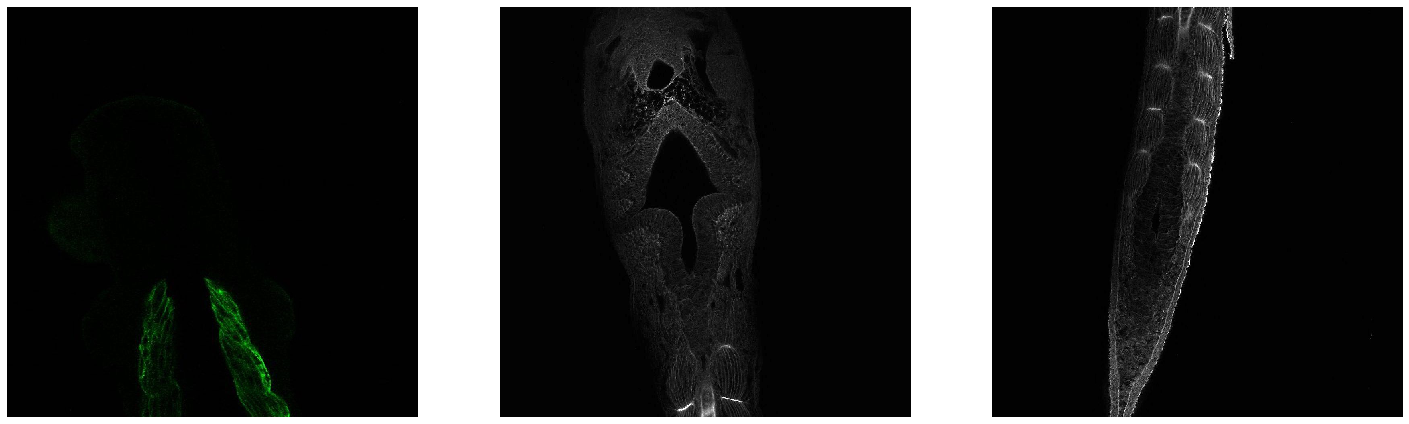

In [0]:
from os import listdir
from os.path import isfile, join
controlpath = "/content/embryo_small/datasets/control/"
files = [f for f in listdir(controlpath) if isfile(join(controlpath, f))]
controlfiles=[]
for f in files:
  controlfiles.append("/content/embryo_small/datasets/control/"+ f)

from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
def showImagesHorizontally(list_of_files):
    fig = figure(figsize = (25, 25))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')
print("control files:")
showImagesHorizontally(controlfiles[0:3])

mutant files:


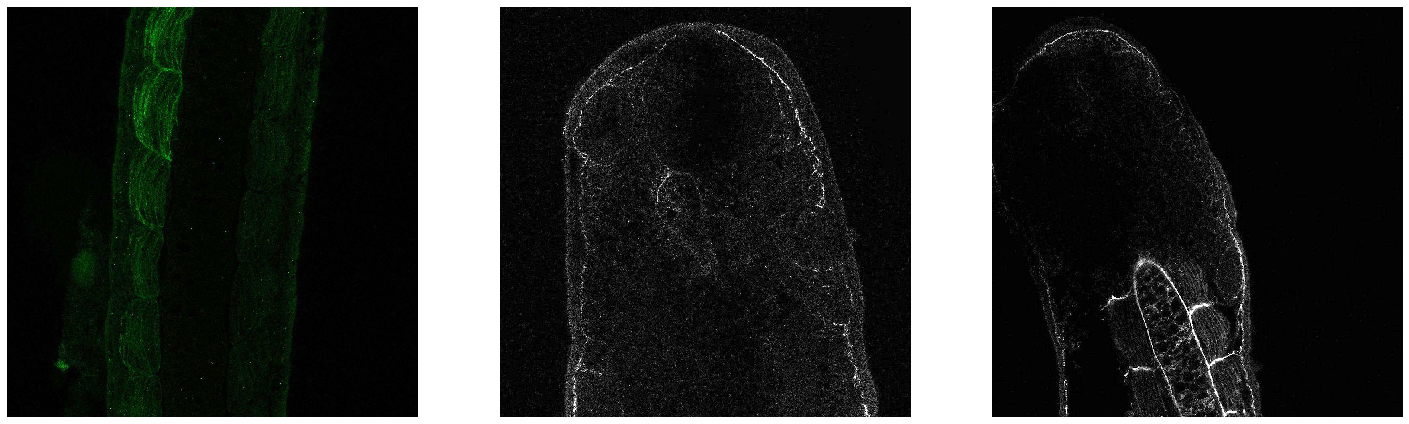

In [0]:
mutiantpath = "/content/embryo_small/datasets/mutant/"
files = [f for f in listdir(mutiantpath) if isfile(join(mutiantpath, f))]
mutantfiles=[]
for f in files:
  mutantfiles.append("/content/embryo_small/datasets/mutant/"+ f)

print("mutant files:")
showImagesHorizontally(mutantfiles[0:3])

### Visualizing the Data

The following code will display some of the training images so we can see what they look like. 

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


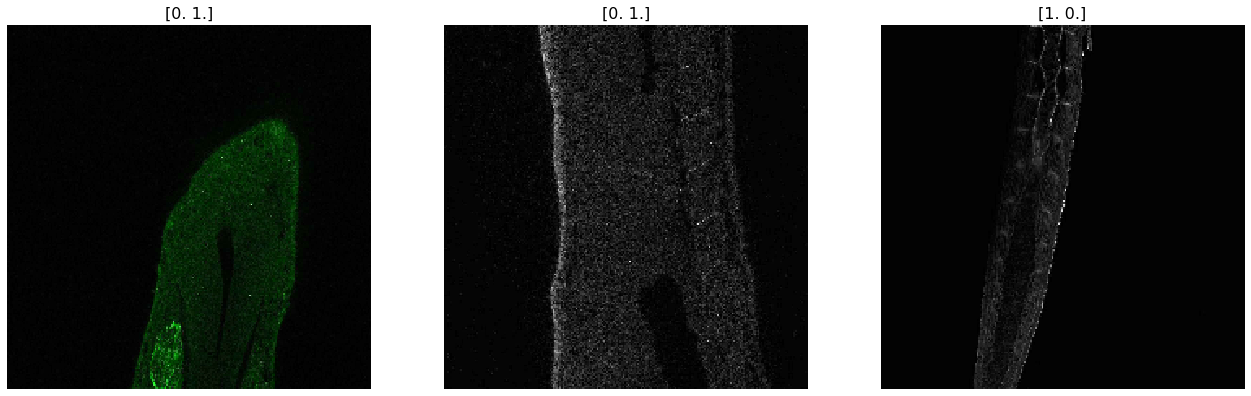

In [0]:
# plots images with labels

def plots(ims, figsize=(30,30), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_batches)
plots(imgs[0:3], titles=labels)

## Creating the Model

In Keras, the deep learning model is represented in layers. 
After importing a pretrained model, a new model is created using this model. While most of these layers will be unmodified, the output layer will be replaced and retrained using the labeled data.

### Loading a Pretrained Model

A pretrained VGG16 model is downloaded using the Keras library. 

In [0]:
vgg16_model = tensorflow.keras.applications.VGG16()

553467904/553467096 [==============================] - 12s 0us/step


### Creating a Custom Output Model#

A new model is created copying all layers except the output layer. Notice that these layers are set to be non-trainable. Finally, a custom output layer is added to the model.  This output layer should have the same number of outputs as the number of different classes of data. The softmax activation function conditions the output to be a probability distribuiton adding up to unity. Therefore, our model will output a probability distribution among the classes as output for each input image.

In [0]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

model.add(Dense(len(classes), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Training the Model

Now that the model has been specified, it must be trained. 




### Compiling the Model
First,the model is compiled. The performance of the model is evalued using a loss function, which increases as performance decreases. Since we are predicting a condition (yes/no), we are using cross-entropy, which is a concept from information theory. If we were instead predicting a scalar value, the correct loss function would be 'mean_squared_error'.

In [0]:
 model.compile(Adam(lr=.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
 print("Done")

Done


### Minimizing Loss

The model is now trained using the backpropagation algorithm to minimize the loss function. The training data will be passed into the model and evaluated using the loss function. Then, the model will be adjusted to decrease the loss.

Here we specifiy the epochs, which is the number of times we pass through the entire training set. These specifications are determined by experimentation with the goal of minimizing validation loss. If the epochs are too high, the model has overfit to the data (too specific). If the epochs are too low, the model has underfit to the data (too general). The validation loss must be compared to training loss to determine if the model is optimally fit to the data.


In [0]:
model.fit(
     train_batches,
     steps_per_epoch = train_batches.samples // 12,
     validation_data = valid_batches, 
     validation_steps = valid_batches.samples // 4,
     epochs=30, 
     verbose=1)
print("Trining Complete!")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 5 steps
Epoch 1/30
5/5 [==============================] - 10s 2s/step - loss: 0.9459 - accuracy: 0.4500 - val_loss: 0.9923 - val_accuracy: 0.3500
Epoch 2/30
5/5 [==============================] - 1s 251ms/step - loss: 0.8481 - accuracy: 0.4833 - val_loss: 0.9542 - val_accuracy: 0.4500
Epoch 3/30
5/5 [==============================] - 1s 252ms/step - loss: 0.7377 - accuracy: 0.6000 - val_loss: 0.8361 - val_accuracy: 0.4500
Epoch 4/30
5/5 [==============================] - 1s 252ms/step - loss: 0.6316 - accuracy: 0.6500 - val_loss: 0.7515 - val_accuracy: 0.4500
Epoch 5/30
5/5 [==============================] - 1s 249ms/step - loss: 0.5875 - accuracy: 0.6833 - val_loss: 0.6946 - val_accuracy: 0.5500
Epoch 6/30
5/5 [==============================] - 1s 249ms/step - loss: 0.5354 - accuracy: 0.7000 - val_loss: 0.6341 - val_accuracy: 0.6000
Epoch 7/30
5/5 [==============================] - 1s 248ms/step - loss: 

## Testing the Model

To perform a final test of the model, the test data is fed through the model.  It is important to use data that was not used in training so we can test the performance accurately. The accuracy is calculated and a confusion matrix is generated. 

### Test Accuracy

To calculate accuracy, the model is evaluated using the test generator specified earlier.

In [0]:
test_loss, test_acc = model.evaluate(test_batches,
                                     steps=1,
                                     verbose=0) 
print(test_loss)
print(test_acc) 

  ...
    to  
  ['...']
0.3191095292568207
0.9


### Confusion Matrix

A confusion matrix gives more insight than just accuracy. It allows us to determine true positives, false positives, false negatives, and true negatives. The code below generates a confusion matrix for our test output

Confusion matrix, without normalization
[[15  0]
 [ 3 12]]


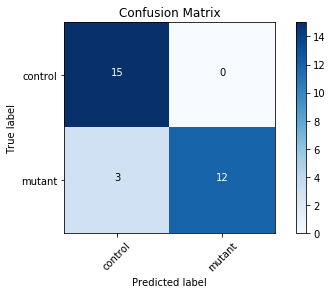

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
test_batches.reset()
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:,0]
predictions = model.predict(test_batches, steps=1, verbose=0)
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

cm_plot_labels = ['control','mutant']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


## Saving the fine-tuned VGG16 model

Now that the model has been trained and tested, it should be saved so we can classify new images without retraining.

In [0]:
model.save('fineTunedVGG16.h5')
print("Model Saved.")

Model Saved.


## Loading the fine-tuned VGG16 model

In a production environment, the model could be loaded.

In [0]:
model.load_weights('fineTunedVGG16.h5')
print("Model Loaded.")

Model Loaded.


## Conclusion

In this notebook, using transfer learning for image classification has been demonstrated. First, the data is uploaded and connected to the Keras API. Then, the model is defined by copying a pretrained model and adding a new output layer. Once defined, the model can be trained using the appropriate loss function. Finally, the model is evaluated using a test dataset. With minimal modification, the model can be used to predict multiple classes beyond two, as well as predicting scalar values. It is encouraged to use this notebook as a templete for similar models using novel datasets. 